In [1]:
import traffic
import pandas as pd 
import os
from traffic.core import Traffic
from biblio_herramienta.herramienta import *
from biblio_herramienta.tratardatos import *

In [2]:
carpetaDatos = r'datos_sectores/' # carpeta que contiene los datos
nombreDatos = "datos_filtrados.csv" 
vuelos = cargardatosfiltrados(carpetaDatos,nombreDatos)
vuelos

count
icao24 callsign       
4ca60f IBK5BV     3683
4cace5 IBK6054    2974
       IBK6055    2343
49514c TAP434M    2175
344495 GES381L    2052
4cacc6 RYR3PE     2036
4853d1 TRA6845    1926
4cabae RYR4Z      1886
3c56f7 EWG4TP     1814
4ca8da RYR6BM     1805

## Cluster
Se va a intentar clasificar las trayectorias en función de su rumbo. Para eso se va utilziar el método enseñado en traffic

In [3]:
vuelos_un = vuelos.assign_id().unwrap().eval(max_workers=4)
vuelos_un.data.head()

,altitude,callsign,groundspeed,icao24,latitude,longitude,timestamp,track,flight_id,track_unwrapped
0,36000.0,IBE31GL,413.0,345685,42.338150,-2.946958,2019-02-05 12:59:39+00:00,21.904506,IBE31GL_225,21.904506
1,36000.0,IBE31GL,413.0,345685,42.340750,-2.945677,2019-02-05 12:59:40+00:00,21.904506,IBE31GL_225,21.904506
2,36000.0,IBE31GL,412.0,345685,42.340750,-2.945677,2019-02-05 12:59:41+00:00,20.767768,IBE31GL_225,20.767768
3,36000.0,IBE31GL,411.0,345685,42.344193,-2.944024,2019-02-05 12:59:42+00:00,19.184735,IBE31GL_225,19.184735
4,36000.0,IBE31GL,411.0,345685,42.345978,-2.943212,2019-02-05 12:59:43+00:00,19.184735,IBE31GL_225,19.184735


## Aplicación del cluster sobre los datos
La siguiente celda tiene el método de cluster aplicado sobre las trayectorias, una vez computado se genera una columna dentro de los datos que señala el cluster al que pertenece cada trayectoria.
El algoritmo usado el es el DBSCAN

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from traffic.core.projection import CH1903

# la funcion permite aplicar algoritmos de ML a los datos que tenemos
vuelos_dbscan = vuelos_un.clustering(
    nb_samples=15, # divide en 15 puntos las trayecorias
    features=["longitude", "latitude", "track_unwrapped"], # datos cebados al algorimto de ML
    clustering=DBSCAN(eps=0.5, min_samples=10), # algoritmo de ML utilizado, con los parámetros del mismo
    transform=StandardScaler(), # lo que hace esto es escalar los datos dentro de una distribuciñ¡ón Gausiana
).fit_predict()


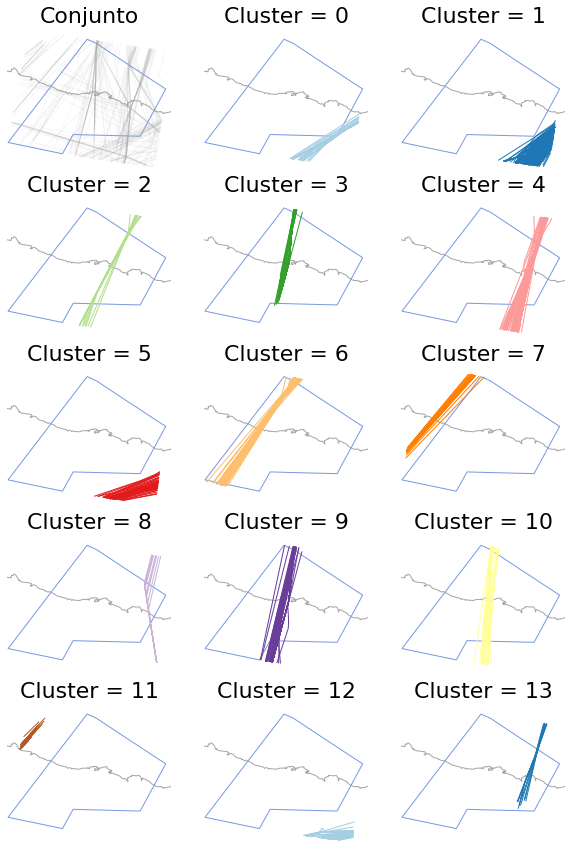

In [5]:
representarcluster(vuelos_dbscan,"cluster_dbscan.png")

In [6]:
from sklearn.cluster import OPTICS
vuelos_optics = vuelos_un.clustering(
    nb_samples = 15,
    features=["longitude", "latitude", "track_unwrapped"],
    transform = StandardScaler(),
    clustering = OPTICS(min_samples=20, eps = 0.5)
).fit_predict()

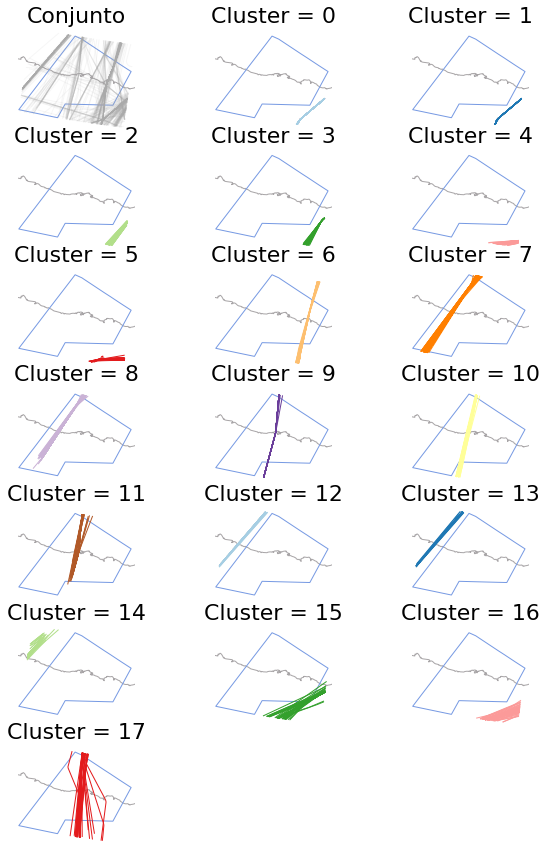

In [7]:
representarcluster(vuelos_optics,"cluster_optics.png")

Este algoritmo de cluster no va a ser demadiaso util debido a que con estos datos genere un cantidad de cluster demasiado específica.  
Ahora se usara Kmeans, este algoritmo es no determinisitico por lo que generara distintos resultados cada vez que se use. Se pondrá un estaod random, y hay que darle el número de clusters que se van a utilizar.


In [8]:
from sklearn.cluster import KMeans
vuelos_kmeans = vuelos_un.clustering(
    nb_samples=15, # divide en 15 puntos las trayecorias
    features=["longitude", "latitude", "track_unwrapped"], # datos cebados al algorimto de ML
    clustering=KMeans(
                     n_clusters = 14,
                     n_init = 10,
                     random_state = 7), # algoritmo de ML utilizado, con los parámetros del mismo
    transform=StandardScaler(), # lo que hace esto es escalar los datos dentro de una distribuciñ¡ón Gausiana
).fit_predict()

In [9]:
def representarcluster1(datos_cluster,nombre_cluster):
    # esta funcion representa el cluster, y lo guarda en una imagen
    n_clusters = 1 + datos_cluster.data.cluster.max() 
    color_cycle = cycle(
        "#a6cee3 #1f78b4 #b2df8a #33a02c #fb9a99 #e31a1c "
        "#fdbf6f #ff7f00 #cab2d6 #6a3d9a #ffff99 #b15928".split()
    )
    colors = list(islice(color_cycle, n_clusters)) 
    colors.append("#aaaaaa") 
    
    nb_cols = 3
    nb_lines = (1 + n_clusters) // nb_cols + (((1 + n_clusters) % nb_cols) > 0)
    
    with plt.style.context("traffic"):
        
  
        fig, ax = plt.subplots(
            nb_lines, nb_cols, figsize=(10, 15), subplot_kw=dict(projection=EuroPP())
            # parametros de la figura y de los ejes
        )

        for cluster in range(-1, n_clusters):
            ax_ = ax[(cluster + 1) // nb_cols][(cluster + 1) % nb_cols]
            ax_.add_feature(countries())
            nm_airspaces['LECMBLU'].plot(ax_,alpha = 1)

            datos_cluster.query(f"cluster == {cluster}").plot(
                ax_, color=colors[cluster], alpha=0.1 if cluster == -1 else 1
            )
            # la funcion de arriba busca la asginación de cluster
            ax_.set_global()
            ax_.set_extent(nm_airspaces['LECMBLU'])
            if cluster == -1:
                ax_.title.set_text("Conjunto")
            else:
                ax_.title.set_text("Cluster = " +str(cluster) )

    guardarimagen("imagenes_cluster",nombre_cluster)

In [10]:
vuelos_kmeans.data.cluster.describe()

count    983195.000000
mean          3.702503
std           3.164128
min           0.000000
25%           2.000000
50%           2.000000
75%           5.000000
max          13.000000
Name: cluster, dtype: float64